In [36]:
# Credits to https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output/notebook

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

In [37]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [38]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 420551 rows, 15 columns


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [39]:
# Data loader to create context window

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In [40]:
# Select only 1 feature for forecasting

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

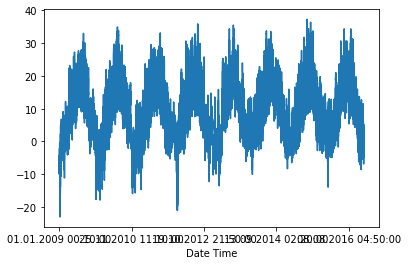

In [41]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [42]:
# Standardization
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


In [43]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [44]:
# Visualize 1 example

print ('Single window of past history. Shape: {}'.format(x_train_uni[0].shape))
print (x_train_uni[0])
print ('\n Target temperature to predict. Shape: {}'.format(y_train_uni[0].shape))
print (y_train_uni[0])

Single window of past history. Shape: (20, 1)
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict. Shape: ()
-2.1041848598100876


In [45]:
# Helper functions
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

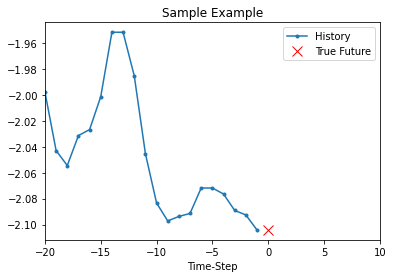

In [46]:
# Visualize 1 example
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [47]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [53]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [54]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 0s 2ms/step
(256, 1)


In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/4
200/200 [==============================] - 4s 9ms/step - loss: 0.2469 - val_loss: 0.0775
Epoch 2/4
200/200 [==============================] - 1s 6ms/step - loss: 0.0799 - val_loss: 0.0438
Epoch 3/4
200/200 [==============================] - 1s 6ms/step - loss: 0.0459 - val_loss: 0.0287
Epoch 4/4
200/200 [==============================] - 1s 6ms/step - loss: 0.0401 - val_loss: 0.0250


8/8 [==============================] - 0s 2ms/step


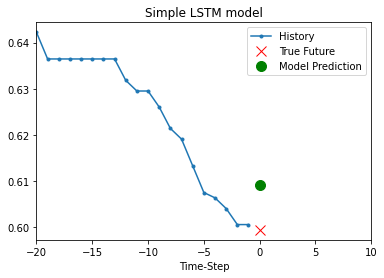

8/8 [==============================] - 0s 2ms/step


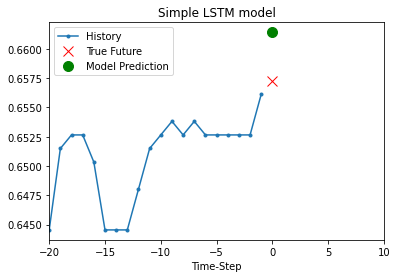

8/8 [==============================] - 0s 3ms/step


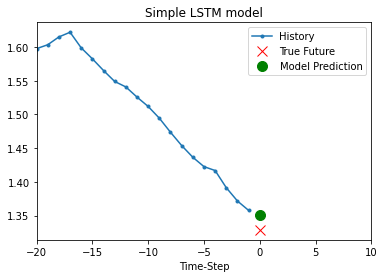

In [56]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()
    

Regression coefficients [ 1.79749216e-03 -2.57665704e-03 -5.17720027e-03  3.89650034e-03
 -7.40860627e-03  3.27465081e-03 -1.12108442e-02  6.50840049e-03
 -1.20736734e-02  5.26963816e-03 -9.20123268e-03 -5.83882043e-03
 -6.27056028e-04 -2.92174021e-03 -2.39173525e-02  2.69466454e-02
 -8.22110067e-02  2.42707988e-01 -6.17739882e-01  1.48917305e+00]
(20, 1)


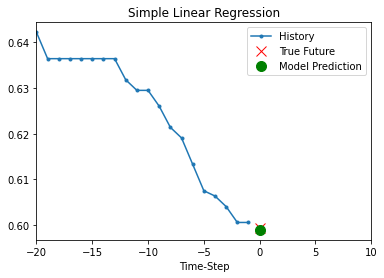

(20, 1)


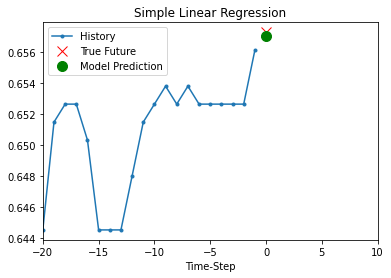

(20, 1)


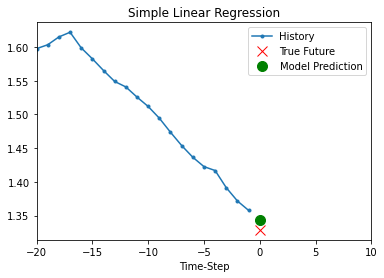

In [74]:
from sklearn.linear_model import LinearRegression

x_train_uni = x_train_uni.reshape(-1, 20)
y_train_uni = y_train_uni.reshape(-1,)
reg = LinearRegression().fit(x_train_uni, y_train_uni)
print("Regression coefficients", reg.coef_)

for x, y in val_univariate.take(3):
    print(x[0].shape)
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    reg.predict(x[0].numpy().reshape(-1,20))[0]], 0, 'Simple Linear Regression')
    plot.show()
